In [26]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from transformers import BertTokenizer, BertModel

# Add Q2/functions to sys.path whether the notebook runs from repo root or /Q2
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q2" / "functions"

sys.path.insert(0, str(functions_dir))

from mlp_utils import train,predict_proba
from eval_utils import evaluate_model  # detailed plots + ROC

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [27]:
if (cwd / "train_df_processed.csv").exists():
    train_path = cwd / "train_df_processed.csv"
    test_path = cwd / "test_df_processed.csv"
else:
    train_path = cwd.parent / "train_df_processed.csv"
    test_path = cwd.parent / "test_df_processed.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Basic safety
train_df = train_df.dropna(subset=["processed_text", "sentiment_class"])
test_df = test_df.dropna(subset=["processed_text", "sentiment_class"])

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)
train_df.head()

train_df: (27463, 12)
test_df : (3531, 11)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text,sentiment_class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"i`d responded, going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!,0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me...,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"sons ****, couldn`t put releases already bought",0


## Train/Val split (stratified)

In [28]:
X_text = train_df["processed_text"].astype(str).values
y = train_df["sentiment_class"].astype(int).values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text,
    y,
    test_size=0.20,
    random_state=SEED,
    stratify=y,
)

X_test_text = test_df["processed_text"].astype(str).values
y_test = test_df["sentiment_class"].astype(int).values

print("Train size:", len(X_train_text))
print("Val size  :", len(X_val_text))
print("Test size :", len(X_test_text))


Train size: 21970
Val size  : 5493
Test size : 3531


# Vectorization: Frozen BERT embeddings 

In [29]:
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BERT_BATCH_SIZE = 64

In [30]:
# External class given by professor in : LLM-Based-Sentiment-Analysis\ELEVES_Sentiment_Analysis_Using_Naive_Bayes.ipynb

class TextDataset(Dataset):
    # Dataset that tokenizes text for BERT
    def __init__(self, texts, labels, tokenizer, max_length):

        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        text = self.texts[idx]
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

def extract_embeddings(bert_model, dataloader, device):

    bert_model.eval()  
    embeddings = []

    with torch.no_grad():  
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.pooler_output  
            embeddings.append(pooled.cpu())
            
    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

## Caching embeddings

In [31]:
out_dir = Path("outputs") if (cwd / "outputs").exists() else (cwd / "Q2" / "outputs")
out_dir.mkdir(parents=True, exist_ok=True)

train_emb_path = out_dir / "bert_train_embeddings.npy"
val_emb_path = out_dir / "bert_val_embeddings.npy"
test_emb_path = out_dir / "bert_test_embeddings.npy"

if train_emb_path.exists() and val_emb_path.exists() and test_emb_path.exists():
    print("Loading cached embeddings from:", out_dir)
    X_train_emb = np.load(train_emb_path)
    X_val_emb = np.load(val_emb_path)
    X_test_emb = np.load(test_emb_path)
else:
    print("Computing BERT embeddings (this may take a while)...")

    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
    bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)

    train_ds = TextDataset(X_train_text, y_train, tokenizer, MAX_LENGTH)
    val_ds = TextDataset(X_val_text, y_val, tokenizer, MAX_LENGTH)
    test_ds = TextDataset(X_test_text, y_test, tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_ds, batch_size=BERT_BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=BERT_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BERT_BATCH_SIZE, shuffle=False)

    train_emb = extract_embeddings(bert, train_loader, device)
    val_emb = extract_embeddings(bert, val_loader, device)
    test_emb = extract_embeddings(bert, test_loader, device)

    X_train_emb = train_emb.numpy()
    X_val_emb = val_emb.numpy()
    X_test_emb = test_emb.numpy()

    np.save(train_emb_path, X_train_emb)
    np.save(val_emb_path, X_val_emb)
    np.save(test_emb_path, X_test_emb)

    print("Saved embeddings to:", out_dir)

print("X_train_emb:", X_train_emb.shape)
print("X_val_emb  :", X_val_emb.shape)
print("X_test_emb :", X_test_emb.shape)


Loading cached embeddings from: outputs
X_train_emb: (21970, 768)
X_val_emb  : (5493, 768)
X_test_emb : (3531, 768)


In [32]:
# 1) Sanity checks
assert not np.isnan(X_train_emb).any(), "NaNs found in train embeddings"
assert not np.isinf(X_train_emb).any(), "Infs found in train embeddings"

# 2) Standardization (recommended for MLP stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_val_scaled = scaler.transform(X_val_emb)
X_test_scaled = scaler.transform(X_test_emb)

print("Scaled embeddings computed.")
print("Train mean (first 5 dims):", X_train_scaled.mean(axis=0)[:5])
print("Train std  (first 5 dims):", X_train_scaled.std(axis=0)[:5])


Scaled embeddings computed.
Train mean (first 5 dims): [ 2.8559361e-07 -9.4230685e-08 -1.5283694e-08 -2.7421663e-08
 -3.2465813e-08]
Train std  (first 5 dims): [0.9999987  0.99999857 1.0000008  0.99999845 0.9999989 ]


In [33]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "x": self.X[idx],
            "label": self.y[idx],
        }

# DataLoaders for the MLP
MLP_BATCH_SIZE = 128

train_loader = DataLoader(EmbeddingDataset(X_train_scaled, y_train), batch_size=MLP_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(EmbeddingDataset(X_val_scaled, y_val), batch_size=MLP_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(EmbeddingDataset(X_test_scaled, y_test), batch_size=MLP_BATCH_SIZE, shuffle=False)

# Modeling

In [34]:
NUM_CLASSES = len(np.unique(y_train))
INPUT_DIM = X_train_scaled.shape[1]

print("INPUT_DIM:", INPUT_DIM)
print("NUM_CLASSES:", NUM_CLASSES)

INPUT_DIM: 768
NUM_CLASSES: 3


## MLP's structure definition

In [35]:
# 1) No hidden layers : 768 -> 3
class LinearHead_baseline(nn.Module):
    def __init__(self):
        super(LinearHead_baseline, self).__init__()
        self.final = nn.Linear(768, NUM_CLASSES)

    def forward(self, x):
        x = x.view(-1, 768)
        x = self.final(x)
        return x

# 2) 768 -> 256 -> 64 -> 3, dropout 0.2, ReLU
class MLP_256_64_drop0_2(nn.Module):
    def __init__(self):
        super(MLP_256_64_drop0_2, self).__init__()
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 64)
        self.final   = nn.Linear(64, NUM_CLASSES)
        self.drop    = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 768)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = self.final(x)
        return x

# 3) 768 -> 128 -> 32 -> 3, dropout 0.2, ReLU
class MLP_128_32_drop0_2(nn.Module):
    def __init__(self):
        super(MLP_128_32_drop0_2, self).__init__()
        self.linear1 = nn.Linear(768, 128)
        self.linear2 = nn.Linear(128, 32)
        self.final   = nn.Linear(32, NUM_CLASSES)
        self.drop    = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 768)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = self.final(x)
        return x

# 4) 768 -> 512 -> 128 -> 3, dropout 0.3, ReLU
class MLP_512_128_drop0_3(nn.Module):
    def __init__(self):
        super(MLP_512_128_drop0_3, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 128)
        self.final   = nn.Linear(128, NUM_CLASSES)
        self.drop    = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 768)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = self.final(x)
        return x

model1 = LinearHead_baseline().to(device)
model2 = MLP_256_64_drop0_2().to(device)
model3 = MLP_128_32_drop0_2().to(device)
model4 = MLP_512_128_drop0_3().to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
nbepoch = 50
lr = 1e-5
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
optimizer4 = optim.Adam(model4.parameters(), lr=lr)

# Trainning

In [37]:
report_dir = Path("reports") if (cwd / "reports").exists() else (cwd / "Q2" / "reports")
report_dir.mkdir(parents=True, exist_ok=True)

### Baseline

In [38]:
for epoch in range(1, nbepoch + 1):
    tr_loss, tr_acc = train(
    model1, train_loader, optimizer1, criterion,
    epoch, nbepoch, device,
    model_name="mlp_baseline", output_dir="outputs")

| Epoch [  1/ 50] Iter[  1/172]	Loss: 1.3429 Acc@1: 24.219%
| Epoch [  1/ 50] Iter[ 51/172]	Loss: 1.1300 Acc@1: 35.938%
| Epoch [  1/ 50] Iter[101/172]	Loss: 1.1184 Acc@1: 36.603%
| Epoch [  1/ 50] Iter[151/172]	Loss: 1.0907 Acc@1: 36.962%
| Epoch [  2/ 50] Iter[  1/172]	Loss: 1.1013 Acc@1: 39.062%
| Epoch [  2/ 50] Iter[ 51/172]	Loss: 1.1018 Acc@1: 40.074%
| Epoch [  2/ 50] Iter[101/172]	Loss: 1.0609 Acc@1: 39.248%
| Epoch [  2/ 50] Iter[151/172]	Loss: 1.0846 Acc@1: 39.073%
| Epoch [  3/ 50] Iter[  1/172]	Loss: 1.0681 Acc@1: 38.281%
| Epoch [  3/ 50] Iter[ 51/172]	Loss: 1.0854 Acc@1: 41.468%
| Epoch [  3/ 50] Iter[101/172]	Loss: 1.0403 Acc@1: 41.971%
| Epoch [  3/ 50] Iter[151/172]	Loss: 1.0493 Acc@1: 41.851%
| Epoch [  4/ 50] Iter[  1/172]	Loss: 1.0747 Acc@1: 37.500%
| Epoch [  4/ 50] Iter[ 51/172]	Loss: 1.0749 Acc@1: 42.463%
| Epoch [  4/ 50] Iter[101/172]	Loss: 1.0586 Acc@1: 43.526%
| Epoch [  4/ 50] Iter[151/172]	Loss: 1.0321 Acc@1: 43.895%
| Epoch [  5/ 50] Iter[  1/172]	Loss: 1.

C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports/mlp_baseline_Full_Report.png


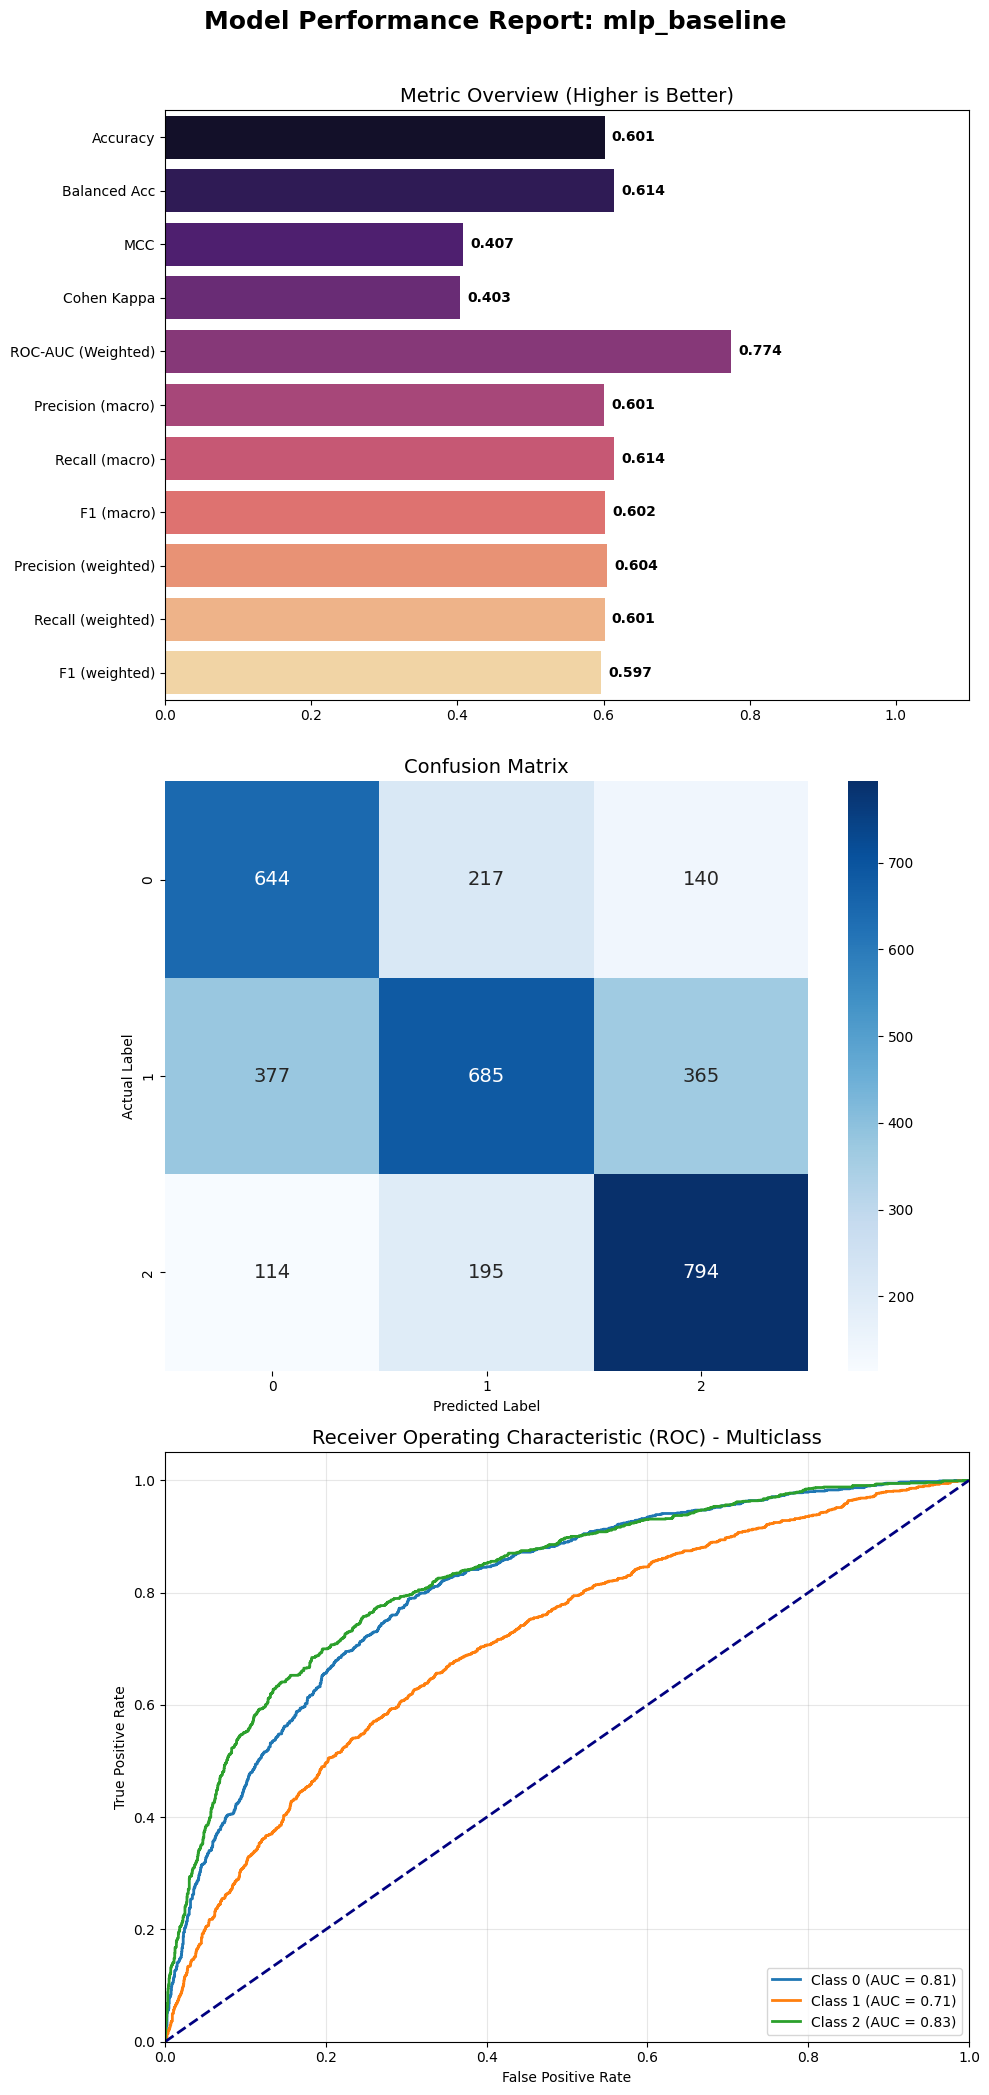

In [39]:
yt_true, yt_pred, yt_probs = predict_proba(model1, test_loader,device)

evaluate_model(
    y_true=yt_true,
    y_pred=yt_pred,
    y_probs=yt_probs,
    model_name="mlp_baseline",
    output_path=str(report_dir),
)